In [1]:
import time
from typing import List, Dict
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import machine_learning_modules as ml
import seaborn as sns

In [2]:
df = ml.read_csv("filtered_df.csv")
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [3]:
# shufle the data into validation and Training data
# Training data is further split into training and test for used during model development
# Validaton is used to assess and evaluate the best model performance.
# Split the data into training and test sets

target_feature = 'Default'
random_state = 42
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(max_iter=1000),
    # LinearDiscriminantAnalysis(),
    # SVC()
]
cv = 10
test_size = 0.35 # default value is 0.2
columns_to_remove = ['LoanID']
random_state = 43
balance_technique = 'oversampling'
    
trained_df, validate_df = ml.shuffle_and_split(df, target_feature, test_size, random_state, columns_to_remove)

In [4]:
trained_df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
197666,53,102418,21289,840,56,4,21.04,24,0.20,Bachelor's,Unemployed,Divorced,Yes,Yes,Other,No,0
255120,61,116055,162409,554,86,2,21.70,36,0.47,Bachelor's,Part-time,Single,No,No,Auto,No,0
143813,29,86592,184776,615,24,4,10.66,24,0.15,PhD,Full-time,Divorced,Yes,Yes,Education,No,0
173623,28,58387,100677,372,39,3,19.39,24,0.15,Master's,Self-employed,Single,No,No,Home,Yes,0
51106,26,105362,135192,644,13,1,22.82,60,0.25,Bachelor's,Self-employed,Married,No,No,Other,Yes,1


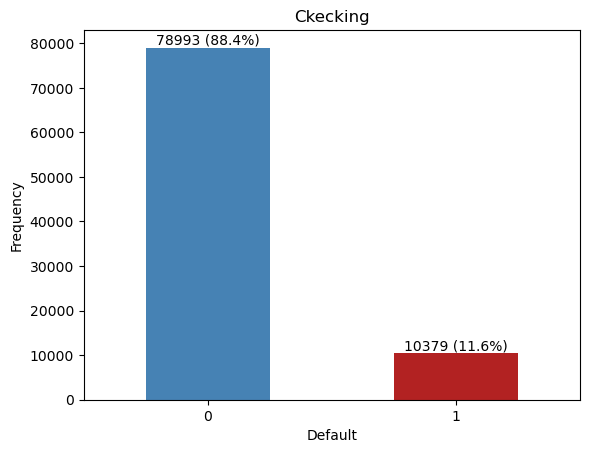

In [9]:
ml.checking_class_dist(validate_df, 'Default', 'Ckecking')

In [11]:
results_df, transformed_feature_names = ml.train_models(trained_df, target_feature, models, balance_technique, test_size, cv)
results_df

Best model RandomForestClassifier saved to best_model_RandomForestClassifier.joblib


,Model,Mean CV Accuracy,CV Accuracy Std,Accuracy,Precision,Recall,F1-Score,Confusion Matrix,Best Model
0,DecisionTreeClassifier,0.915941,0.001772,0.921707,0.931133,0.921707,0.921277,"[[43529, 7816], [224, 51122]]",False
1,RandomForestClassifier,0.979078,0.000978,0.984809,0.985018,0.984809,0.984807,"[[50032, 1313], [247, 51099]]",True
2,LogisticRegression,0.684224,0.004631,0.684471,0.684500,0.684471,0.684458,"[[34821, 16524], [15878, 35468]]",False


In [25]:
#list(transformed_feature_names)

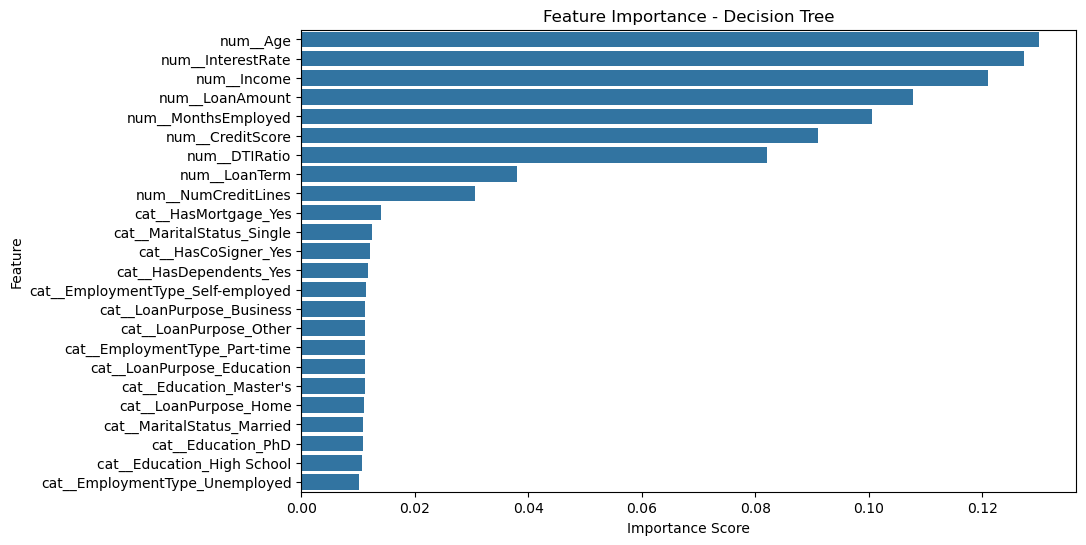

In [23]:
# Load the model
loaded_model = ml.load_model("best_model_RandomForestClassifier.joblib")

# Extract feature importances
feature_importances = loaded_model.feature_importances_

# Create a DataFrame to visualize feature importance
importance_df = pd.DataFrame({
    'Feature': list(transformed_feature_names),
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df[importance_df['Importance'] != 0]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - RandomForestClassifier')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [ ]:
import shap

# Load your model
loaded_model = ml.load_model("best_model_RandomForestClassifier.joblib")

# Get your training data (replace with your actual training data)
X_train = your_training_data

# Explain the model using SHAP
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.explain(X_train)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train)

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got RandomForestClassifier() instead.

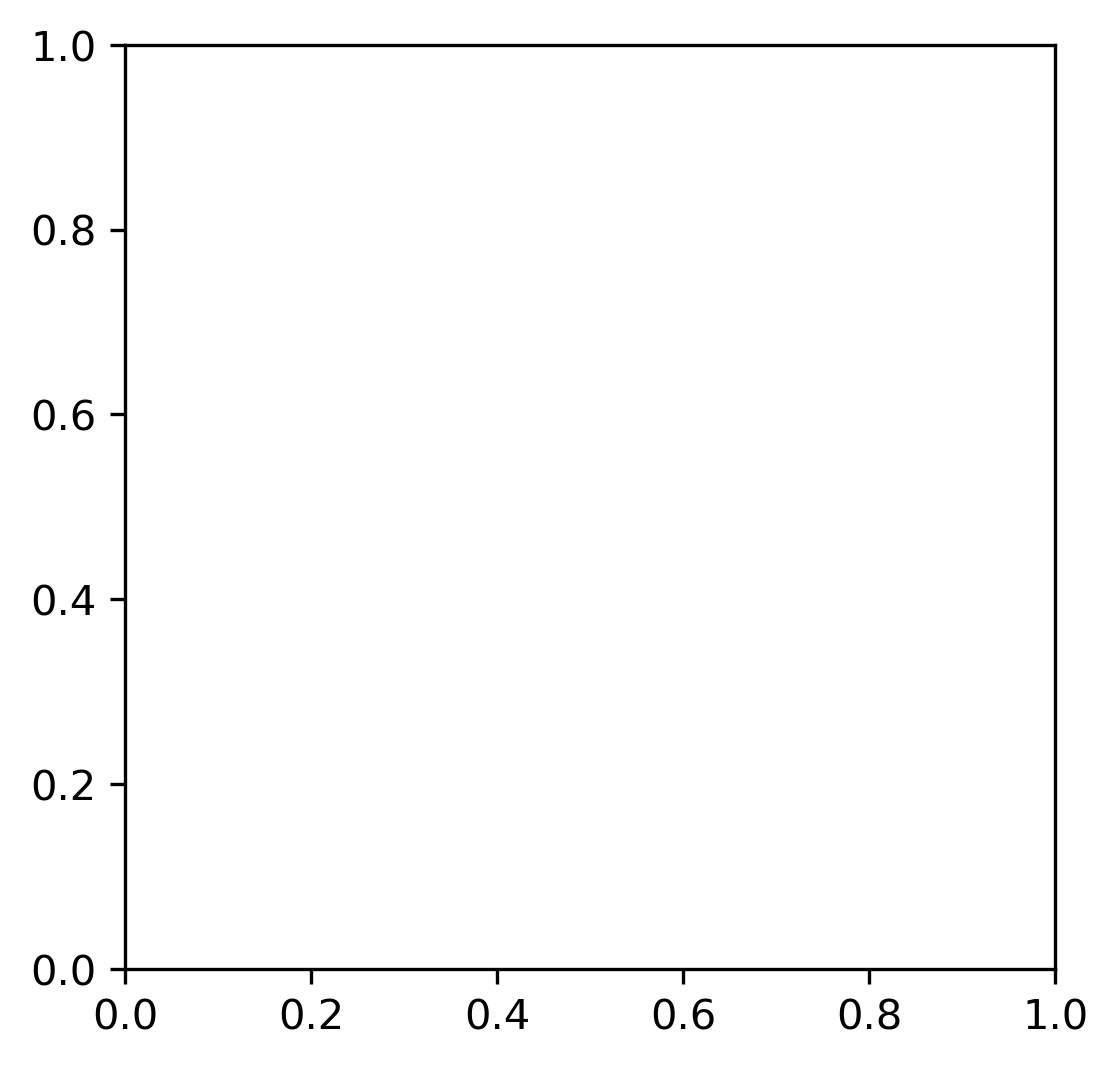

In [31]:
from sklearn import tree
fn = list(transformed_feature_names)
cn = ['Y','N']

#fig = plt.figure(figsize=(25,20))
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(loaded_model,
               feature_names = fn, 
               class_names=cn,
               filled = True);

In [47]:
len(feature_importances)

24

In [49]:
len(validate_df.drop(target_feature, axis=1).columns)

16

In [13]:
# Load the best model
loaded_model = ml.load_model("best_model_RandomForestClassifier.joblib")

Model loaded from best_model_RandomForestClassifier.joblib


In [15]:
def evaluate_model_on_validation_set(model, X_val, y_val):
    """
    Evaluates the model on a validation set and prints performance metrics.

    Args:
        model: Trained model instance.
        X_val (pd.DataFrame): Features of the validation set.
        y_val (pd.Series): True labels of the validation set.
    """
    # Predict on the validation set
    y_pred = model.predict(X_val)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    cm = confusion_matrix(y_val, y_pred)

    # Print performance metrics
    print("Validation Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

In [33]:
X_val

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
72172,20,116599,46854,734,107,1,12.71,12,0.78,Bachelor's,Self-employed,Single,No,No,Home,No
224715,34,112510,160513,454,19,4,17.63,24,0.32,PhD,Unemployed,Single,Yes,Yes,Home,Yes
203860,36,27603,132780,569,118,2,19.07,36,0.45,High School,Unemployed,Married,No,No,Other,No
126051,38,37241,87193,570,85,1,20.97,60,0.28,Master's,Part-time,Divorced,Yes,No,Home,No
107698,60,17395,54733,339,0,3,12.85,48,0.46,Master's,Part-time,Married,No,Yes,Education,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79131,69,113917,165131,584,40,3,9.97,36,0.76,Bachelor's,Full-time,Married,Yes,Yes,Education,No
163112,36,84761,13195,461,64,3,2.58,48,0.38,High School,Self-employed,Married,No,Yes,Auto,Yes
146814,35,65411,110708,493,43,2,7.89,60,0.75,Bachelor's,Full-time,Single,No,Yes,Auto,Yes
255173,29,123543,221578,453,74,3,8.39,24,0.48,Bachelor's,Unemployed,Divorced,Yes,Yes,Home,Yes


In [31]:
X_val = validate_df.drop(target_feature, axis=1)
y_val = validate_df[target_feature]
evaluate_model_on_validation_set(loaded_model, X_val, y_val)

C:\Users\seune\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: "Bachelor's"

In [31]:
#ml.plot_best_model_explanation(results_df, models, trained_df, target_feature, test_size, extra_columns_to_remove)

In [ ]:
 # Split the data into features and target
    X = df.drop(columns=[target_feature])
    y = df[target_feature]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state,
                                                        test_size=test_size, stratify=y)

    # Identify categorical and numerical columns
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X_train.select_dtypes(include=['number', 'int64', 'float64']).columns.tolist()

    # Define column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    # Preprocess the data
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

#### Data Splitting

#### Using Cross_Validation

The technique of cross validation (CV) is best explained by example using the most common method, K-Fold CV. When we approach a machine learning problem, 

1. we make sure to split our data into a training and a testing set. 
2. In K-Fold CV, we further split our training set into K number of subsets, called folds. 
3. We then iteratively fit the model K times (i.e fit 5 models in 5 Folds CV), each time training the data on K-1 of the folds and evaluating on the Kth fold (called the validation data). 

As an example, consider fitting a model with K = 5. The first iteration we train on the first four folds and evaluate on the fifth. The second time we train on the first, second, third, and fifth fold and evaluate on the fourth. We repeat this procedure 3 more times, each time evaluating on a different fold. 

4. At the very end of training, we average the performance on each of the folds to come up with final validation metrics for the model.

For hyperparameter tuning, we perform many iterations of the entire K-Fold CV process, each time using different model settings. We then compare all of the models, select the best one, train it on the full training set, and then evaluate on the testing set. 

Instead of following this manual process RandomSearchCV and GridSearch automate the process.

In [35]:

#seed = 7
#kfold = model_selection.KFold(n_splits=10, random_state=seed)
kfold = model_selection.KFold(n_splits=10)
model = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print(("Accuracy: %.3f (%.3f)") % (results.mean(), results.std()))

Accuracy: 0.814 (0.060)


#### Hyperparameter Tuning for Logistic Regression

When creating a ML model it is often difficult to define which model architecture that will optimise the model.  A model is optimised at a point where the model can strike a balance between overfitting and underfitting. Hence, GridSearch and RandomSearch are two method of searching for the optimum point for a model optimization by exploring a range of different possibilities. 

1. The objective of the model parameter is to learn the patterns in the input features for it to be able to predict the output feature. Model parameter are learned by the model during the training process.

2. Hyperparameter's object is to reduce the loss. i.e achieving a point where the model is optimised.

#### 1. Using GridSearch 

GridSearch can be used to find the optimum parameters of the logistic regressor.

In [39]:
dual=[True,False]
max_iter=[2.5,3,3.5,4,4.5]
param_grid=dict(dual=dual,max_iter=max_iter)

In [41]:
log_reg = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=log_reg,param_grid=param_grid,cv=10,n_jobs=1)

start_time=time.time()
grid_result = grid.fit(X_train,y_train)

#summary of results
print ("Best: %f using %s" %(grid_result.best_score_,grid_result.best_params_))
print ("Execution time: " + str((time.time()- start_time)) + 'ms')

C:\Users\seune\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\seune\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Best: 0.769444 using {'dual': False, 'max_iter': 4}
Execution time: 0.7709364891052246ms


C:\Users\seune\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.70555556        nan 0.76944444        nan]
  warnings.warn(
C:\Users\seune\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
#summary of results
print ("Best: %f using %s" %(grid_result.best_score_,grid_result.best_params_))
print ("Execution time: " + str((time.time()- start_time)) + 'ms')

Best: 0.769444 using {'dual': False, 'max_iter': 4}
Execution time: 30.320932388305664ms


In [45]:
dual=[True,False]
max_iter=[1,2,3,4,5]
C = [1.0,1.5,2.0,2.5]
param_grid=dict(dual=dual,max_iter=max_iter)

In [47]:
log_reg = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=log_reg,param_grid=param_grid,cv=10,n_jobs=1)

start_time=time.time()
grid_result = grid.fit(X_train,y_train)

C:\Users\seune\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\seune\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

In [49]:
#summary of results
print("Best: %f using %s" %(grid_result.best_score_,grid_result.best_params_))
print ("Execution time: " + str((time.time()- start_time)) + 'ms')

Best: 0.805556 using {'dual': False, 'max_iter': 5}
Execution time: 9.608636617660522ms


#### 2. Random Search

In [57]:
random = RandomizedSearchCV(estimator=log_reg, param_distributions=param_grid, cv=10, n_jobs=-1)
start_time=time.time()
random_result = random.fit(X_train,y_train)



C:\Users\seune\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\seune\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\seune\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\seune\AppData\Local\anaconda3\Lib\site-packages\sklearn\lin

In [59]:
#summary of results
print("Best: %f using %s" %(random_result.best_score_,random_result.best_params_))
print ("Execution time: " + str((time.time()- start_time)) + 'ms')

Best: 0.805556 using {'max_iter': 5, 'dual': False}
Execution time: 24.58357858657837ms
